# BiSeNet 구현  
- pytorch로 구현

In [1]:
import os
import time
import random
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from torchcallback import EarlyStopping, CheckPoint
from torchlosses import OhemCELoss, DiceLoss
from torchmetrics import Metrics
from torchscheduler import PolynomialLRDecay

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

# Load Data

In [3]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv(r'C:\Users\user\MY_DL\segmentation\bisenet\cityscapes\class_map.csv', index_col=0)

rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

data

,r,g,b
name,,,
unlabeled,0,0,0
dynamic,111,74,0
ground,81,0,81
road,128,64,128
sidewalk,244,35,232
parking,250,170,160
rail track,230,150,140
building,70,70,70
wall,102,102,156


In [4]:
width = 256
height = 128
num_classes = len(data)

# cuda setting
device = torch.device('cuda')
print(device)

cuda


In [5]:
def load_image_with_resize(path, n_pixel_L, n_pixel_R, subset='train'):
    image_list, label_list = [], []
    image_files = glob(path+'/images/'+subset+'/**/*.png')
    label_files = glob(path+'/labels/'+subset+'/**/*.png')
    
    for file in tqdm(image_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (n_pixel_L, n_pixel_R), cv2.INTER_NEAREST)
        image_list.append(img)
        
    for file in tqdm(label_files):
        if 'color.png' in file.split('_'):
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (n_pixel_L, n_pixel_R), cv2.INTER_NEAREST)
            label_list.append(img)
    return np.array(image_list), np.array(label_list)
    
path = './cityscapes'
train_image, train_label = load_image_with_resize(path=path, 
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='train')
valid_image, valid_label = load_image_with_resize(path=path,
                                                  n_pixel_L=width, n_pixel_R=height, 
                                                  subset='valid')
test_image, test_label = load_image_with_resize(path=path, 
                                                n_pixel_L=width, n_pixel_R=height,
                                                subset='test')

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/8925 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1525 [00:00<?, ?it/s]

  0%|          | 0/4575 [00:00<?, ?it/s]

In [6]:
rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

In [7]:
# image to 12 classes mask
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)
test_mask = image2mask(test_label)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
# custom data set
class CityscapesDataset(Dataset):
    def __init__(self, transforms_, subset='train', predict_train=False):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            if predict_train:
                self.images = train_image[:100]
                self.labels = train_mask[:100]
            else:
                self.images = train_image
                self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [9]:
batch_size = 12

transforms_ = [
    transforms.ToTensor(),
]

train_loader = DataLoader(
    CityscapesDataset(transforms_=transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    CityscapesDataset(transforms_=transforms_, subset='valid'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

## Build Model

In [10]:
# Conv + Batch Normalization + ReLU
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=2, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU(inplace=True)
        # initialize weights
        self._init_weight_()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [11]:
# Define Spatial Path
class SpatialPath(nn.Module):
    # input size of image is batch size x 3 x width x height
    # and default value of filter is 64
    def __init__(self, in_dim=3, num_filters=64):
        # Spatial Path has layers of 3 ConvBlock 
        super(SpatialPath, self).__init__()
        # input channel: 3
        self.convblock1 = ConvBlock(in_dim, num_filters)
        # output channel: 64, size: 1/2
        self.convblock2 = ConvBlock(num_filters, num_filters*2)
        # output channel: 128, size: 1/4
        self.convblock3 = ConvBlock(num_filters*2, num_filters*4)
        # output channel: 256, size: 1/8
        
        # initialize weights
        self._init_weight_()
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [12]:
# Define Attention Refinement Module
class AttentionRefinementModule(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBlock(in_dim, out_dim, kernel_size=3, stride=1, padding=1)
        # 1x1 kernel conv layer
        self.conv_atten = nn.Conv2d(out_dim, out_dim, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_dim)
        self.sigmoid = nn.Sigmoid()
        
        # initialize weights
        self._init_weight_()
        
    def forward(self, inputs):
        feat = self.conv(inputs)
        x = torch.mean(feat, dim=(2,3), keepdim=True)
        x = self.conv_atten(x)
        x = self.bn(x)
        x = self.sigmoid(x)
        out = torch.mul(feat, x)
        return out
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [13]:
class ResNet(nn.Module):
    def __init__(self, pretrained_model='resnet18'):
        super(ResNet, self).__init__()
        
        # load pre-trained model called lightweight model in context path
        if pretrained_model=='resnet18':
            features = models.resnet18(pretrained=True)
        elif pretrained_model=='resnet101':
            features = models.resnet101(pretrained=True)
        else:
            raise ValueError('You should be select resnet18 or resnet101')
            
        self.conv = features.conv1
        self.bn = features.bn1
        self.relu = features.relu
        self.maxpool = features.maxpool
        # 4x down sampling
        self.layer1 = features.layer1
        # 8x down sampling
        self.layer2 = features.layer2
        # 16x down sampling
        self.layer3 = features.layer3
        # 32x down sampling
        self.layer4 = features.layer4
        
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        feat4 = self.layer1(x)
        feat8 = self.layer2(feat4)
        feat16 = self.layer3(feat8)
        feat32 = self.layer4(feat16)
        return feat16, feat32

In [14]:
# Define Context Path
class ContextPath(nn.Module):
    def __init__(self, out_dim=num_classes, pretrained_model='resnet18'):
        super(ContextPath, self).__init__()
        
        # load pre-trained model 
        self.resnet = ResNet(pretrained_model=pretrained_model)
        
        # using attention refinement module
        if pretrained_model=='resnet18':
            self.arm16 = AttentionRefinementModule(256, 128)
            self.arm32 = AttentionRefinementModule(512, 128)
            self.conv_avg = ConvBlock(512, 128, kernel_size=1, stride=1, padding=0)
            self.conv16 = ConvBlock(128, 128, kernel_size=3, stride=1, padding=1)
            self.conv32 = ConvBlock(128, 128, kernel_size=3, stride=1, padding=1)
            
        elif pretrained_model=='resnet101':
            self.arm16 = AttentionRefinementModule(1024, 256)
            self.arm32 = AttentionRefinementModule(2048, 256)
            self.conv_avg = ConvBlock(2048, 256, kernel_size=1, stride=1, padding=0)
            self.conv16 = ConvBlock(256, 256, kernel_size=3, stride=1, padding=1)
            self.conv32 = ConvBlock(256, 256, kernel_size=3, stride=1, padding=1)
            
        self.up16 = nn.Upsample(scale_factor=2.)
        self.up32 = nn.Upsample(scale_factor=2.)
        
        # initalize weights
        self._init_weight_()
        
    def forward(self, inputs):
        # load pre-trained resnet
        feat16, feat32 = self.resnet(inputs)
        
        # global average pooling operation
        avg = torch.mean(feat32, dim=(2,3), keepdim=True)
        avg = self.conv_avg(avg)
        
        # operate feature 32 features layer
        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg
        feat32_up = self.up32(feat32_sum)
        feat32_up = self.conv32(feat32_up)
        
        # operate feature 16 features layer
        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = self.up16(feat16_arm)
        feat16_up = self.conv16(feat16_up)
        
        return feat32_up, feat16_up
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [15]:
# Define Feature Fusion Module
class FeatureFusionModule(nn.Module):
    def __init__(self, in_dim, out_dim):
        # this module needs two inputs and concatenate inputs
        super(FeatureFusionModule, self).__init__()
        # conv + bn + relu
        self.convblock = ConvBlock(in_dim, out_dim, kernel_size=1, stride=1, padding=0)
        # 1x1 convolution layer
        self.conv1 = nn.Conv2d(out_dim, out_dim, kernel_size=1, stride=1, padding=0)
        # relu activation function
        self.relu = nn.ReLU(inplace=True)
        # 1x1 convolution layer
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=1, stride=1, padding=0)
        # sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        
        # initialize weights
        self._init_weight_()
        
    def forward(self, input_1, input_2):
        # FFM receives two inputs and concatenate with dimension 1
        x = torch.cat((input_1, input_2), dim=1)
        # keep features for mul
        features = self.convblock(x)
        x = torch.mean(features, dim=(2,3), keepdim=True)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        # mul operation
        x = torch.mul(features, x)
        # add operation
        x = features + x
        return x

    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [16]:
class BiSeNetOutput(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim=num_classes, up_factor=8.):
        super(BiSeNetOutput, self).__init__()
        
        self.convblock = ConvBlock(in_dim, mid_dim, kernel_size=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(mid_dim, out_dim, kernel_size=1, bias=True)
        self.up = nn.Upsample(scale_factor=up_factor, mode='bilinear', align_corners=False)
        self._init_weight_()
        
    def forward(self, x):
        x = self.convblock(x)
        x = self.conv_out(x)
        x = self.up(x)
        return x
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, 1)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [17]:
# build BiSeNet
class BiSeNet(nn.Module):
    def __init__(self, num_classes=num_classes, pretrained_model='resnet18', mode='train'):
        super(BiSeNet, self).__init__()
        # load Spatial Path
        self.spatial_path = SpatialPath()
        # load Context Path
        self.context_path = ContextPath(pretrained_model=pretrained_model)
        # load feature fusion module
        if pretrained_model=='resnet18':
            self.feature_fusion = FeatureFusionModule(256+128, 128)
            self.conv_out32 = BiSeNetOutput(128, 64, num_classes, up_factor=16)
            self.conv_out16 = BiSeNetOutput(128, 64, num_classes, up_factor=8)
            
        elif pretrained_model=='resnet101':
            self.feature_fusion = FeatureFusionModule(256+256, 128)
            self.conv_out32 = BiSeNetOutput(256, 64, num_classes, up_factor=16)
            self.conv_out16 = BiSeNetOutput(256, 64, num_classes, up_factor=8)
            
        else:
            raise ValueError('You should be select resnet18 or resnet101')
        # output layer
        self.bisenet_output = BiSeNetOutput(128, 64, num_classes, up_factor=8.)
        
        # initialize weights
        self._init_weight_()
        
    def forward(self, inputs):
        # Spatial Path
        sx = self.spatial_path(inputs)
        # Context Path
        feat32, feat16 = self.context_path(inputs)
        # FFM
        ffm_output = self.feature_fusion(sx, feat16)
        # upsampling
        output = self.bisenet_output(ffm_output)
        
        # extract arm16 output and amr32 output for calculate auxiliary loss 
        out32 = self.conv_out32(feat32)
        out16 = self.conv_out16(feat16)
        
        return output, out16, out32
    
    def _init_weight_(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

In [18]:
model = BiSeNet(pretrained_model='resnet101').to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         ConvBlock-4         [-1, 64, 112, 112]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
         ConvBlock-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
             ReLU-11          [-1, 256, 28, 28]               0
        ConvBlock-12          [-1, 256, 28, 28]               0
      SpatialPath-13          [-1, 256, 28, 28]               0
           Conv2d-14         [-1, 64, 1

# Set Loss function, Optimizer, learning rate scheduler and early stopping  

**Loss**  
- base loss: log softmax  
$$loss = \frac{1}{N}\sum_i-\log\left(\frac{e^{p_i}}{\sum_je^{p_j}}\right)$$  
$$L\left(X;W\right)=l_p\left(X;W\right)+\alpha\sum_{i=1}^Kl_i\left(X_i;W\right)$$  
- $l_p$: principal loss  
- $l_i$: auxiliary loss  
- $X_i$: Xception model의 $i$번째 output  
- $K=3$  
- $\alpha=1$

In [19]:
lr = 1e-4
es_save_path = './model/es_checkpoint.pt'
cp_save_path = './model/cp_checkpoint.pt'
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
lr_scheduler = PolynomialLRDecay(optimizer, max_decay_steps=100)
metric = Metrics(n_classes=num_classes, dim=1) # mIoU, BF score
checkpoint = CheckPoint(verbose=True, path=cp_save_path)
early_stopping = EarlyStopping(patience=100, verbose=True, path=es_save_path)

In [20]:
def train(model,
          train_data,
          validation_data,
          epochs,
          learning_rate_scheduler=False,
          check_point=False,
          early_stop=False,
          last_epoch_save_path='./model/last_checkpoint.pt'):
    # create empty list to append losses and mious of train, validation
    loss_list, miou_list, bf_list = [], [], []
    val_loss_list, val_miou_list, val_bf_list = [], [], []
    ############################# training #############################
    # train the model
    model.train()
    starting = time.time()
    # start training
    for epoch in tqdm(range(epochs)):
        init_time = time.time()
        # train by batch
        batch_loss_list, batch_miou_list, batch_bf_list = [], [], []
        for train_images, train_labels in train_data:
            # assign to gpu device
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            
            # initialize the gradient to 0
            optimizer.zero_grad()
            # model predict
            output_images, out16, out32 = model(train_images)
            miou = metric.mean_iou(output_images, train_labels)
            p_loss = loss_func(output_images, train_labels)
            a_loss1 = loss_func(out16, train_labels)
            a_loss2 = loss_func(out32, train_labels)
            loss = p_loss + (a_loss1+a_loss2)
            
            bf = metric.f1_score(output_images, train_labels)
            
            # update loss and optimizer
            loss.backward()
            optimizer.step()
            
            batch_loss_list.append(loss.item())
            batch_miou_list.append(miou.item())
            batch_bf_list.append(bf.item())
            
        end_time = time.time()
        loss_list.append(torch.Tensor(batch_loss_list).mean())
        miou_list.append(torch.Tensor(batch_miou_list).mean())
        bf_list.append(torch.Tensor(batch_bf_list).mean())
        # check epoch, loss, miou and time
        print(f'\n[Epoch {epoch+1}/{epochs}]'
              f'  [time: {end_time-init_time:.3f}s]'
              f'  [lr = {optimizer.param_groups[0]["lr"]}]')
        print(f'[train loss: {torch.Tensor(batch_loss_list).mean():.3f}]'
              f'  [train mIoU: {torch.Tensor(batch_miou_list).mean():.3f}]'
              f'  [train BF: {torch.Tensor(batch_bf_list).mean():.3f}]')
        
        ############################# validate #############################
        # validate the model
        vbatch_loss_list, vbatch_miou_list, vbatch_bf_list = [], [], []
        with torch.no_grad():
            for val_images, val_labels in validation_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs, val_out16, val_out32 = model(val_images)
                val_p_loss = loss_func(val_outputs, val_labels)
                val_a_loss1 = loss_func(val_out16, val_labels)
                val_a_loss2 = loss_func(val_out32, val_labels)
                val_loss = val_p_loss + (val_a_loss1+val_a_loss2)
                val_miou = metric.mean_iou(val_outputs, val_labels)
                val_bf = metric.f1_score(val_outputs, val_labels)
                
                vbatch_loss_list.append(val_loss.item())
                vbatch_miou_list.append(val_miou.item())
                vbatch_bf_list.append(val_bf.item())
                
                if learning_rate_scheduler:
                    lr_scheduler.step(epoch+1)
                    
            val_loss_list.append(torch.Tensor(vbatch_loss_list).mean())
            val_miou_list.append(torch.Tensor(vbatch_miou_list).mean())
            val_bf_list.append(torch.Tensor(vbatch_bf_list).mean())
            # check loss and miou of validation
            print(f'[valid loss: {torch.Tensor(vbatch_loss_list).mean().item():.3f}]'
                  f'  [valid mIoU: {torch.Tensor(vbatch_miou_list).mean():.3f}]'
                  f'  [valid BF: {torch.Tensor(vbatch_bf_list).mean():.3f}]')
            
        v_loss = torch.Tensor(vbatch_loss_list).mean()
        # save model check point
        if check_point:
            checkpoint(v_loss, model)
            
        # set early stopping
        if early_stop:
            assert check_point==False, 'Choose between Early Stopping and Check Point'
            early_stopping(v_loss, model)
            if early_stopping.early_stop:
                print('\n##########################\n'
                      '##### Early Stopping #####\n'
                      '##########################')
                break
                
    # if we not set early stopping, the model save at the end of training
    if early_stop==False and check_point==False:
        torch.save(model.state_dict(), last_epoch_save_path)
        print('Saving model of last epoch')
        
    ending = time.time()
    print(f'\n Total time for training is {ending-starting:.3f}s')
    
    return model, loss_list, miou_list, bf_list, val_loss_list, val_miou_list, val_bf_list

In [21]:
EPOCH = 30

model, train_loss, train_miou, train_bf, valid_loss, valid_miou, valid_bf = train(
    model,
    train_loader,
    validation_data=valid_loader,
    epochs=EPOCH,
    learning_rate_scheduler=False,
    check_point=True,
    early_stop=False,
)

  0%|          | 0/30 [00:00<?, ?it/s]


[Epoch 1/30]  [time: 30.975s]  [lr = 9.910855285787058e-05]
[train loss: 5.634]  [train mIoU: 0.131]  [train BF: 0.121]
[valid loss: 4.449]  [valid mIoU: 0.158]  [valid BF: 0.135]
Validation loss decreased (inf --> 4.449).  Saving model ...

[Epoch 2/30]  [time: 31.445s]  [lr = 9.910855285787058e-05]
[train loss: 3.976]  [train mIoU: 0.172]  [train BF: 0.145]
[valid loss: 3.758]  [valid mIoU: 0.170]  [valid BF: 0.151]
Validation loss decreased (4.449 --> 3.758).  Saving model ...

[Epoch 3/30]  [time: 31.370s]  [lr = 9.910855285787058e-05]
[train loss: 3.460]  [train mIoU: 0.181]  [train BF: 0.159]
[valid loss: 3.419]  [valid mIoU: 0.179]  [valid BF: 0.162]
Validation loss decreased (3.758 --> 3.419).  Saving model ...

[Epoch 4/30]  [time: 31.401s]  [lr = 9.910855285787058e-05]
[train loss: 3.170]  [train mIoU: 0.189]  [train BF: 0.169]
[valid loss: 3.214]  [valid mIoU: 0.184]  [valid BF: 0.171]
Validation loss decreased (3.419 --> 3.214).  Saving model ...

[Epoch 5/30]  [time: 31.3

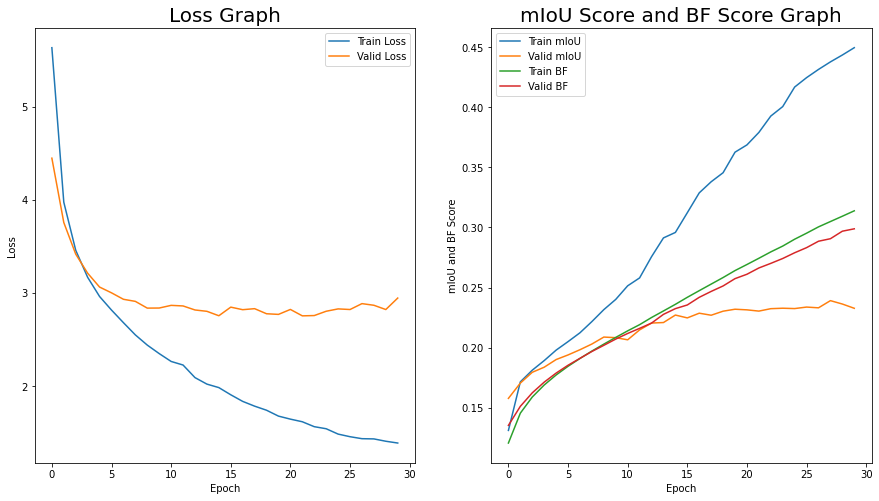

In [24]:
# check losses and miou scores graph
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].set_title('Loss Graph', fontsize=20)
ax[0].plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
ax[0].plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('mIoU Score and BF Score Graph', fontsize=20)
ax[1].plot(np.arange(len(train_miou)), train_miou, label='Train mIoU')
ax[1].plot(np.arange(len(valid_miou)), valid_miou, label='Valid mIoU')
ax[1].plot(np.arange(len(train_bf)), train_bf, label='Train BF')
ax[1].plot(np.arange(len(valid_bf)), valid_bf, label='Valid BF')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('mIoU and BF Score')
ax[1].legend(loc='best')
fig.show()

# Check performance of model

In [25]:
# load test data
test_loader = DataLoader(
    CityscapesDataset(transforms_, subset='test'),
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
)

In [26]:
# test
loss_list, miou_list, bf_list = [], [], []

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # predict
        test_outputs, _, _ = model(test_images)
        test_loss = loss_func(test_outputs, test_labels)
        test_miou = metric.mean_iou(test_outputs, test_labels)
        test_bf = metric.f1_score(test_outputs, test_labels)
        
        loss_list.append(test_loss.item())
        miou_list.append(test_miou.item())
        bf_list.append(test_bf.item())
        
    print(f'Test Loss: {torch.Tensor(loss_list).mean():.3f},'
          f'  Test mIoU: {torch.Tensor(miou_list).mean():.3f}'
          f'  Test BF: {torch.Tensor(bf_list).mean():.3f}')

Test Loss: 6.293,  Test mIoU: 0.072  Test BF: 0.168


In [27]:
# 12 classes channels to 3 RGB channels
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return np.array(rgb_img_list)

test_result = mask2rgb(test_outputs)
test_mask = test_labels
test_labels = mask2rgb(test_labels)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

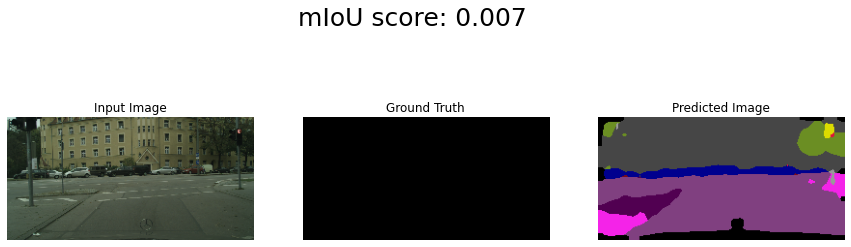

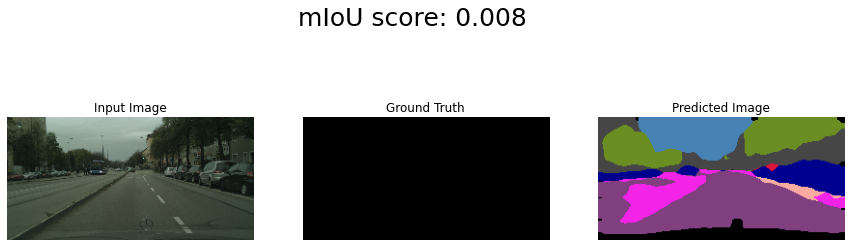

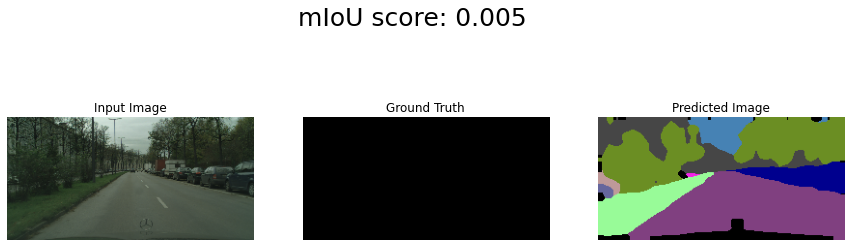

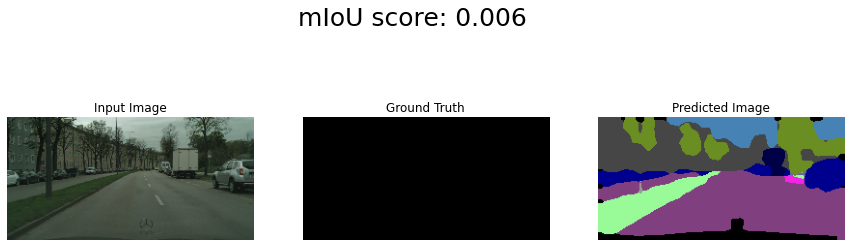

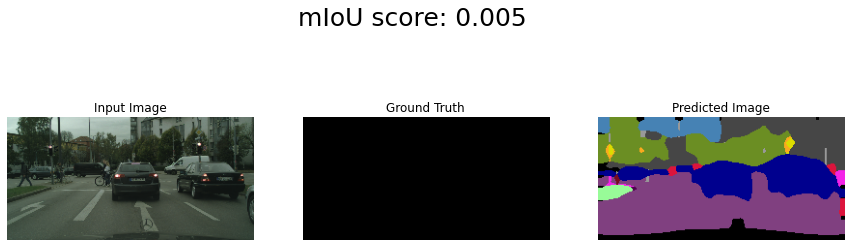

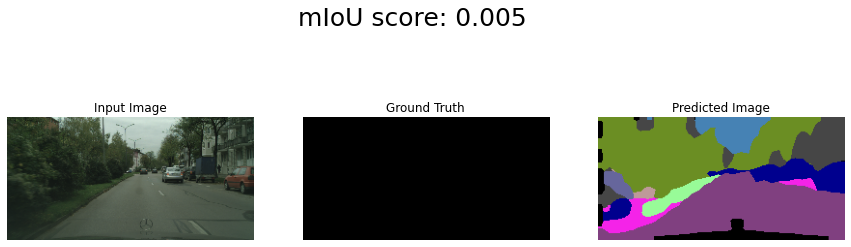

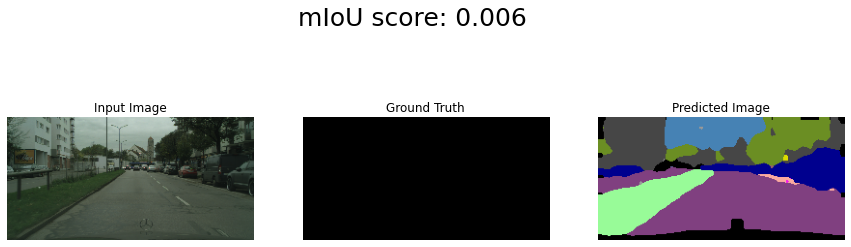

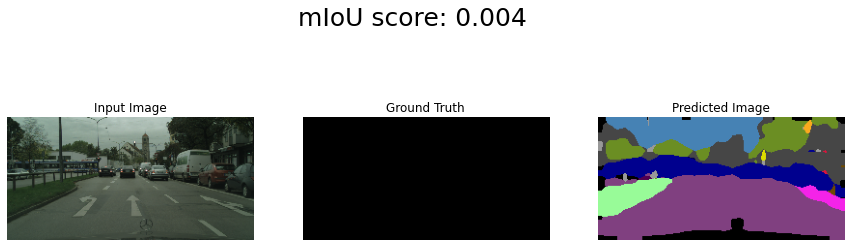

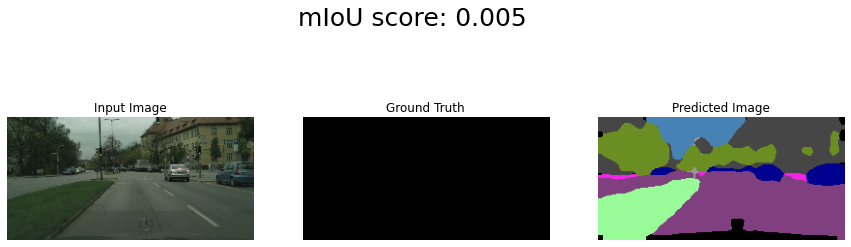

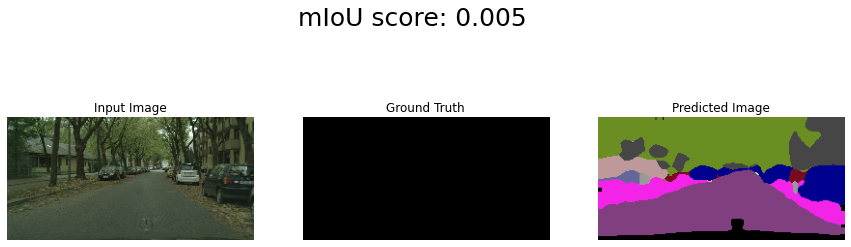

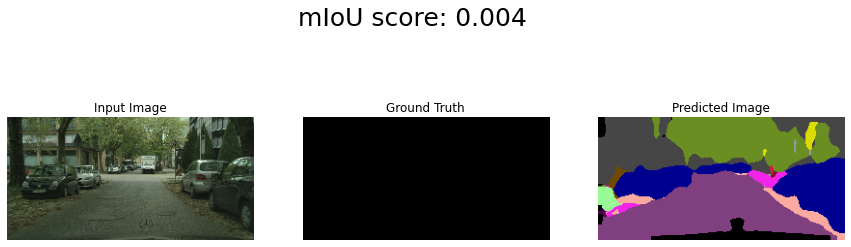

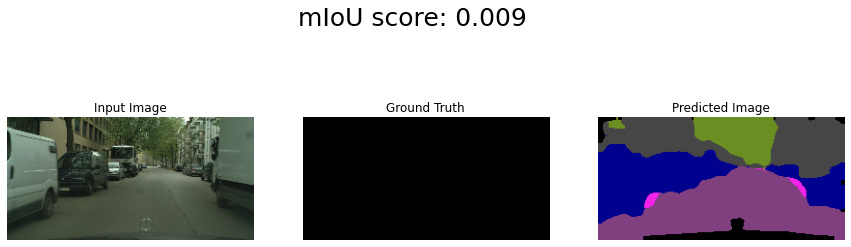

In [37]:
# show test outputs with miou score
figure_metric = Metrics(n_classes=num_classes, dim=0)

def cuda2numpy(tensors):
    tensors = tensors.detach().cpu().numpy()
    return np.transpose(tensors, (0,2,3,1))

def show_result(input_image, label_image, mask_image, pred_mask, pred_image, ncols):
    input_image = cuda2numpy(input_image)
    for i in range(ncols):
        # get miou score
        miou = figure_metric.mean_iou(mask_image[i], pred_mask[i])
        # plot images
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        fig.suptitle(f'mIoU score: {miou:.3f}', fontsize=25)
        ax[0].imshow(input_image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label_image[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(pred_image[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted Image')
        fig.show()

show_result(test_images, test_labels, test_mask, test_outputs, test_result, batch_size)

In [38]:
# model이 train data에 대해 잘 훈련됐는지 확인
train_loader = DataLoader(
    CityscapesDataset(transforms_=transforms_, subset='train', predict_train=True),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [39]:
# test
loss_list, miou_list, bf_list = [], [], []

with torch.no_grad():
    for train_images, train_labels in train_loader:
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        # predict
        train_outputs, _, _ = model(train_images)
        train_loss = loss_func(train_outputs, train_labels)
        train_miou = metric.mean_iou(train_outputs, train_labels)
        train_bf = metric.f1_score(train_outputs, train_labels)
        
        loss_list.append(train_loss.item())
        miou_list.append(train_miou.item())
        bf_list.append(train_bf.item())
        
    print(f'Train Loss: {torch.Tensor(loss_list).mean():.3f},'
          f'  Train mIoU: {torch.Tensor(miou_list).mean():.3f},'
          f'  Train BF: {torch.Tensor(bf_list).mean():.3f}')
        
train_result = mask2rgb(train_outputs)
train_mask = train_labels
train_labels = mask2rgb(train_labels)

Train Loss: 0.467,  Train mIoU: 0.394,  Train BF: 0.314


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

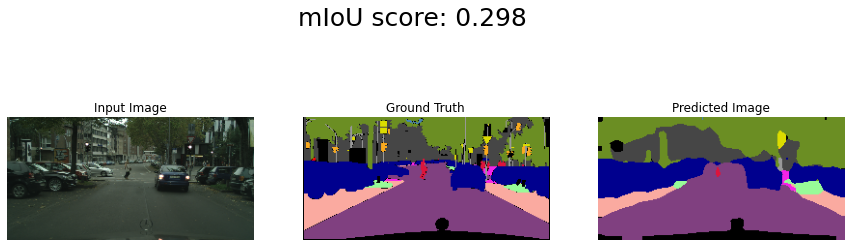

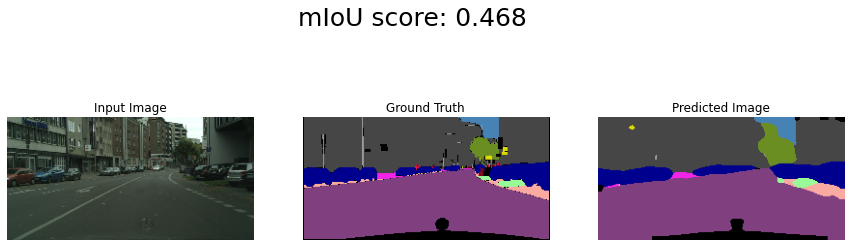

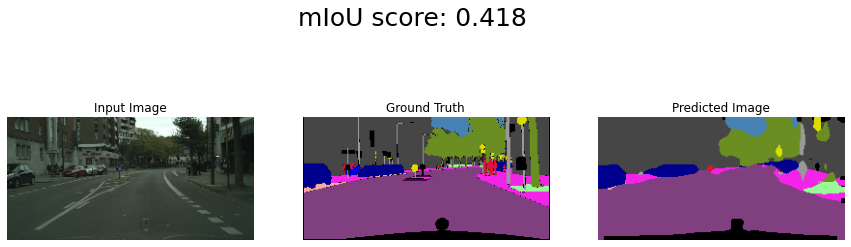

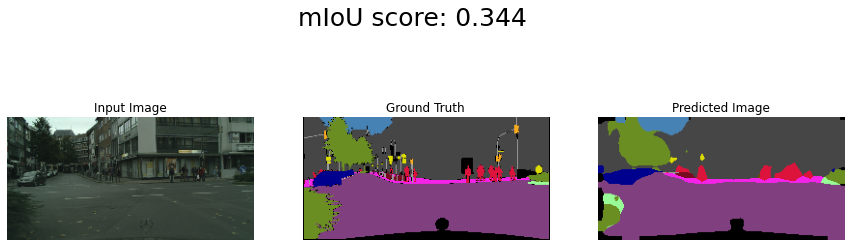

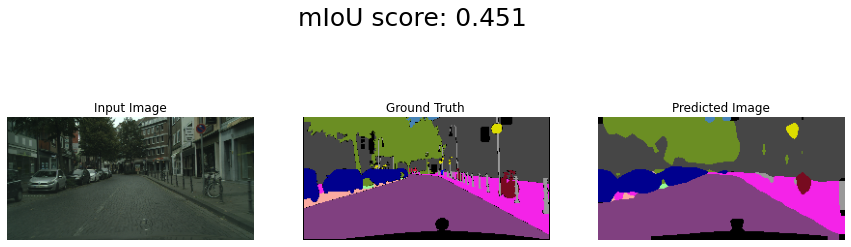

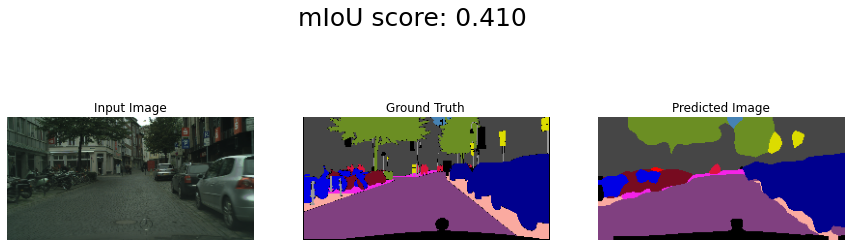

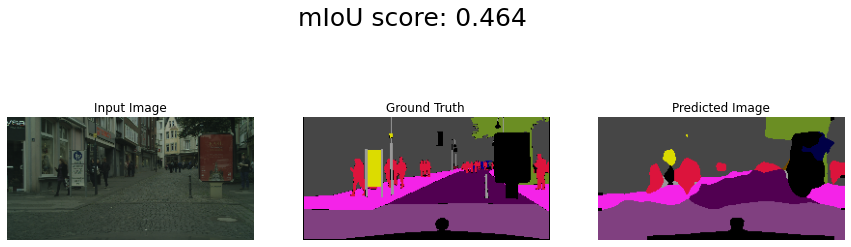

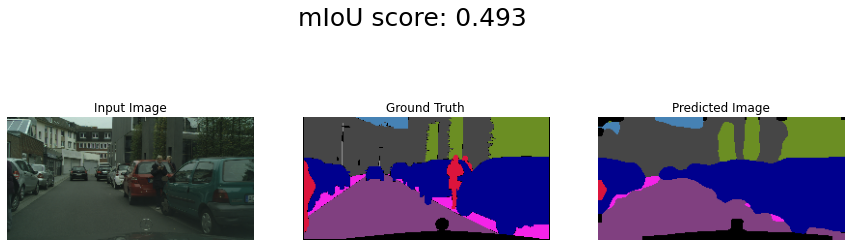

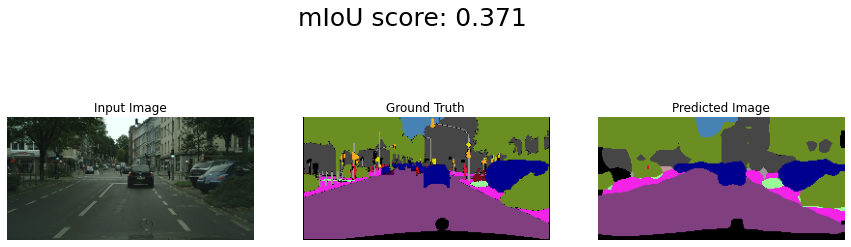

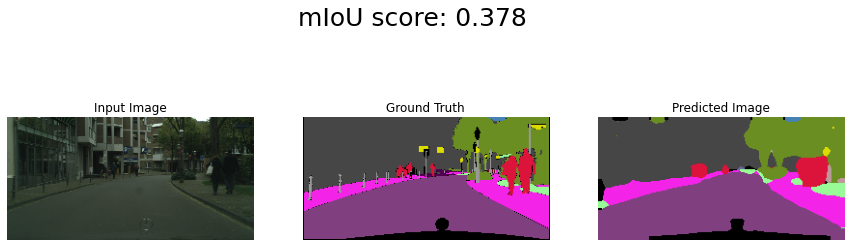

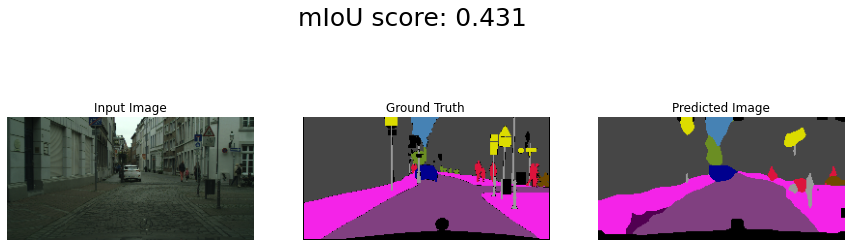

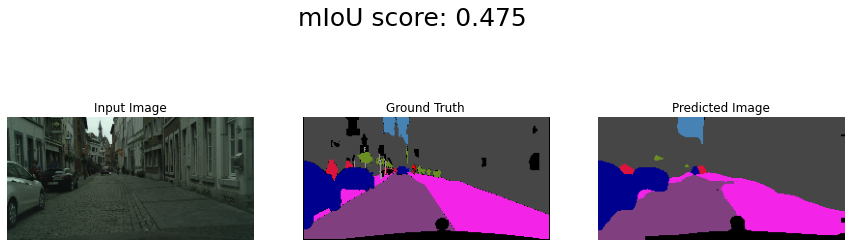

In [40]:
show_result(train_images, train_labels, train_mask, train_outputs, train_result, batch_size)